# WSI - ćwiczenie 7
*Tomasz Żebrowski*

Celem zadania było stworzenie narzędzia do wnioskowania przy użyciu sieci Bayesa i zademonstrowanie jego mozliwości na przykładzie systemu alarmowego.

Omawiany system można opisać za pomocą pięciu binarnych zmiennych losowych. Zależności między nimi są zgodne z tymi przedstawionymi na wykładzie, a na potrzeby wykorzystania w programie reprezentuję je w poniższy sposób:

In [1]:
# Tabela prawdopodobieństw
probability_table = {
    "T": [ # Wystąpienie trzęsienia ziemi
        (None, 0.02)
        ],
    "W": [ # Włamanie
        (None, 0.01)
        ],
    "A": [ # Załączenie alarmu
        ([("W", True), ("T", True)], 0.95),
        ([("W", True), ("T", False)], 0.94),
        ([("W", False), ("T", True)], 0.29),
        ([("W", False), ("T", False)], 0.001)
        ],
    "J": [ # Telefon od Jana
        ([("A", True)], 0.90),
        ([("A", False)], 0.05)
    ],
    "M": [ # Telefon od Magdy
        ([("A", True)], 0.70),
        ([("A", False)], 0.01)
    ],
}

Algorytm MCMC z próbkowaniem Gibbsa zaimplementowałem w pliku `bayes.py` jako metodę klasy `BayesNet`. Poniższy kod tworzy obiekt tej klasy reprezentujący sieć o zadanych połączeniach.

In [2]:
from bayes import BayesNet

net = BayesNet(probability_table)

Weryfikuję czy algorytm działa poprawnie wyznaczając z jego pomocą znane z założeń zadania prawdopodobieństwa.

In [3]:
results = {}
for variable in probability_table:
    if probability_table[variable][0][0] is None:
        results[f"P({variable})"] = net.mcmc({}, variable, 100000)
    else:
        for variant in probability_table[variable]:
            evidence = {}
            for evidence_element in variant[0]:
                evidence[evidence_element[0]] = evidence_element[1]
            results[f"P({variable}|{evidence})"] = net.mcmc(evidence, variable, 100000)

In [4]:
correct_probability = [0.02, 0.01, 0.95, 0.94, 0.29, 0.001, 0.90, 0.05, 0.70, 0.01]
print(f"{'Liczone prawdopodobieństwo':28}{'Wynik programu':17}{'Prawidłowy wynik':16}")
for index, result in enumerate(results):
    print(f"{result:32}{results[result]:4.4f}{correct_probability[index]:16.4f}")

Liczone prawdopodobieństwo  Wynik programu   Prawidłowy wynik
P(T)                            0.0193          0.0200
P(W)                            0.0110          0.0100
P(A|{'W': True, 'T': True})     0.9508          0.9500
P(A|{'W': True, 'T': False})    0.9412          0.9400
P(A|{'W': False, 'T': True})    0.2924          0.2900
P(A|{'W': False, 'T': False})   0.0009          0.0010
P(J|{'A': True})                0.9014          0.9000
P(J|{'A': False})               0.0507          0.0500
P(M|{'A': True})                0.7021          0.7000
P(M|{'A': False})               0.0102          0.0100


Widać, że dla tak dużej liczby iteracji (100000) wyniki wyznaczone przez program są bardzo bliskie wartościom rzeczywistym. Ponadto, wyznaczenie ich nie zajęło bardzo dużo czasu.

### Prezentacja możliwości programu
Oczywiście stworzone narzędzie pozwala na realizację wielu innych rodzajów zadań poza wyznaczeniem już znanych prawdopodobieństw.

Pierwszym z nich może być wyznaczenie łącznych prawdopodobieństw dla wszystkich zdarzeń (Przy braku wiedzy o systemie)

In [5]:
results = {}
for variable in probability_table:
    results[f"P({variable})"] = net.mcmc({}, variable, 100000)
print("Liczone prawdopodobieństwo\tWynik programu")
for result in results:
    print(f"{result:24}\t{results[result]:4.4f}")

Liczone prawdopodobieństwo	Wynik programu
P(T)                    	0.0199
P(W)                    	0.0093
P(A)                    	0.0125
P(J)                    	0.0632
P(M)                    	0.0209


W przypadku zdarzeń `T` i `W` wyniki są te same co poprzednio, również zgodne z założeniami zadania. Pozostałe prawdopodobieństwa zgadzają się z tymi, które można uzyskać licząć te prawdopodobieństwa ręcznie.

Program można zastosować do typów zadań wymienionych w wykładzie:
1. Zadanie diagnostyczne:   Magda zadzwoniła; Czy było włamanie?
2. Zadanie predykcyjne:     Było włamanie; Czy zadzwoni Jan?
3. Zadanie wyjaśniające:    Włączył się alarm i było trzęsienie ziemi; Czy nie było również włamania?
4. Zadanie mieszane:        Było trzęsienie ziemi i zadzwonił Jan; Czy włączył się też alarm?

In [6]:
# Zadanie 1
print("Zadanie diagnostyczne")
result_1 = net.mcmc({"M": True}, "W", 100000)
print(f"P(W|{{'M': True}}) = {result_1:4.4f}")

Zadanie diagnostyczne
P(W|{'M': True}) = 0.3092


In [7]:
# Zadanie 2
print("Zadanie predykcyjne")
jan = net.mcmc({"W": True}, "J", 100000)
print(f"P(J|{{'W': True}}) = {jan:4.4f}")

Zadanie predykcyjne
P(J|{'W': True}) = 0.8483


In [8]:
# Zadanie 3
print("Zadanie wyjaśniające")
result_3 = net.mcmc({"A": True, "T" : True}, "W", 100000)
print(f"P(W|{{'A': True, 'T': True}}) = {result_3:4.4f}")

Zadanie wyjaśniające
P(W|{'A': True, 'T': True}) = 0.0315


In [9]:
# Zadanie 3
print("Zadanie mieszane")
result4 = net.mcmc({"T": True, "J": True}, "A", 100000)
print(f"P(A|{{'T': True, 'J': True}}) = {result4:4.4f}")

Zadanie mieszane
P(A|{'T': True, 'J': True}) = 0.8816


In [16]:
import matplotlib.pyplot as plt
net.mcmc({"M": True}, "W", 10000000)

0.3115208

### Eksperymenty
Dla zadania 1 badam zależność czasu obliczeń i wyników wnioskowania od liczby iteracji.

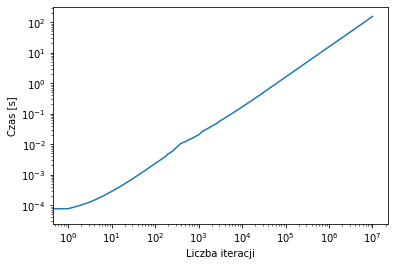

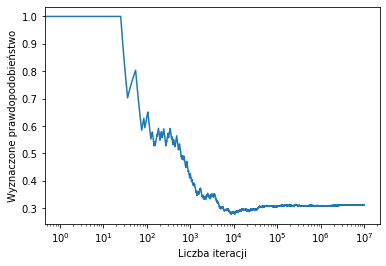

In [22]:

time_series = net.history["time"]
probability_series = net.history["probability"]
plt.plot(time_series)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Liczba iteracji")
plt.ylabel("Czas [s]")
plt.show()
plt.plot(probability_series)
plt.xscale("log")
plt.xlabel("Liczba iteracji")
plt.ylabel("Wyznaczone prawdopodobieństwo")
plt.show()

Na pierwszym wykresie widać, że czas zależy od liczby iteracji w przybliżeniu liniowo. Widać wypłaszczenie na początku krzywej - wynika z obliczeń, które program wykonuje poza pętlą algorytmu.

Na drugim wykresie widać wynik działania programu w zależności od liczby iteracji. Widać, że przez pierwsze kilkanaście iteracji wynik utrzymuje się na 1.0 (Mogłoby to być też 0.0). Wynika to z tego, że stan interesującej zmiennej  został początkowo zainicjowany właśnie tą wartością. Szybko jednak wartość prawdopodobieństwa się zmienia. Na początku widoczne są duże wahania tej wartości pomiędzy iteracjami, które są redukowane w ramach działania programu. Ostatecznie, wartość stabilizuje się w okolicach prawidłowego rozwiązania i powoli do niego zbiega.

Patrząc na oba wykresy można stwierdzić, że dla otrzymania satysfakcjonujących wyników wystarczy 100000 iteracji, co zapewni dość krótkie obliczenia (w pojedynczych sekundach).

W kolejnym eksperymencie sprawdzam czy szybkość zbieżności algorytmów do rozwiązania zależy od rozwiązywanego zadania. 

In [28]:
tasks = [
    {"evidence": {"M": True}, "query": "W"},
    {"evidence": {"W": True}, "query": "J"},
    {"evidence": {"A": True, "T": True}, "query": "W"},
    {"evidence": {"T": True, "J": True}, "query": "A"},
]

results = []

for task in tasks:
    net.mcmc(task["evidence"], task["query"], 1000000)
    results.append({
        "time": net.history["time"],
        "probability": net.history["probability"]
    })

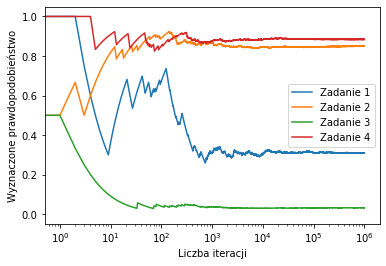

In [29]:
for result in results:
    plt.plot(result["probability"])
plt.legend(["Zadanie 1", "Zadanie 2", "Zadanie 3", "Zadanie 4"], loc="best")
plt.xscale("log")
plt.xlabel("Liczba iteracji")
plt.ylabel("Wyznaczone prawdopodobieństwo")
plt.show()

W zbadanym przypadku nie widać wyraźnej zależności szybkości zbieżności do rozwiązania od rodzaju zadania. Eksperyment powtórzę dla dwóch ekstremalnie inaczej uwarunkowanych zadań.

In [30]:
tasks = [
    {"evidence": {}, "query": "A"},
    {"evidence": {"W": True, "T": False, "J": True, "M": False}, "query": "A"},
]

results2 = []

for task in tasks:
    net.mcmc(task["evidence"], task["query"], 1000000)
    results2.append({
        "time": net.history["time"],
        "probability": net.history["probability"]
    })

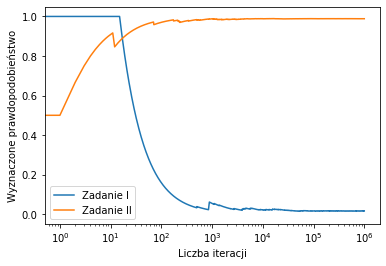

In [35]:
for result in results2:
    plt.plot(result["probability"])
plt.legend(["Zadanie I", "Zadanie II"], loc="best")
plt.xscale("log")
plt.xlabel("Liczba iteracji")
plt.ylabel("Wyznaczone prawdopodobieństwo")
plt.show()

W tym przypadku zadanie I jest zadaniem, gdzie nie ma żadnych obserwacji, natomiast w zadaniu II wszystkie zmienne oprócz badanej są zaobserwowane.

Widać, że zbieżność do rozwiązania dla zadania II jest zauważalnie szybsza niż dla zadania I. Wynika to z tego, że aproksymacja stanu sieci jest prawidłowa od samego początku zadania kiedy wszystkie zmienne są zaobserwowane - algorytm nie ma dużego pola do przeszukiwań.

To, że jeden z przypadków zbiega szybciej widać wyraźniej przy zastosowaniu skali liniowej i spojrzeniu na kilka pierwszych iteracji (rysunek poniżej).

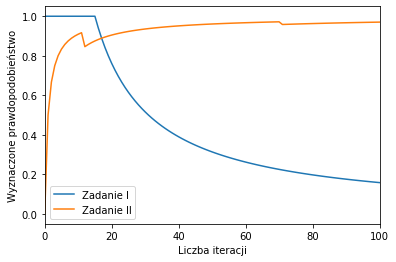

In [38]:
for result in results2:
    plt.plot(result["probability"])
plt.legend(["Zadanie I", "Zadanie II"], loc="best")
plt.xlabel("Liczba iteracji")
plt.xlim(0, 100)
plt.ylabel("Wyznaczone prawdopodobieństwo")
plt.show()

Sprawdzam czas wykonania obliczeń w zależności od zadania.

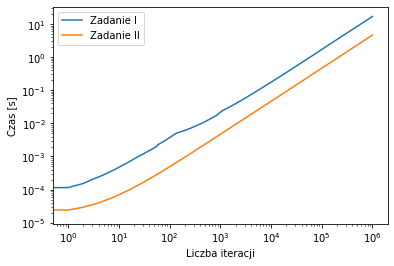

In [39]:
for result in results2:
    plt.plot(result["time"])
plt.legend(["Zadanie I", "Zadanie II"], loc="best")
plt.xscale("log")
plt.xlabel("Liczba iteracji")
plt.ylabel("Czas [s]")
plt.yscale("log")
plt.show()

Widać, że w przypadku zadania o większej liczbie obserwacji czas obliczeń jest także mniejszy. Wynika to z tego, że w każdej iteracji algorytm próbkuje wszystkie nieznane zmienne, których w takim przypadku jest mniej.

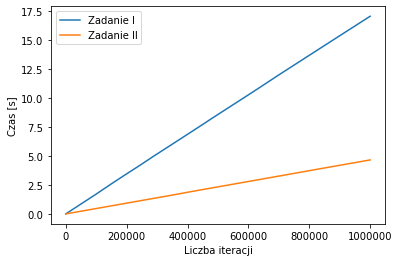

In [40]:
for result in results2:
    plt.plot(result["time"])
plt.legend(["Zadanie I", "Zadanie II"], loc="best")
plt.xlabel("Liczba iteracji")
plt.ylabel("Czas [s]")
plt.show()

Przy zastosowaniu skali liniowej widać, że zadanie II jest rzeczywiście znacznie lepiej uwarunkowane jeśli chodzi o czas wykonania obliczeń.